# General metrics

In [8]:
# lee el csv con todas las predicciones y obtiene métricas
import pandas as pd
import numpy as np

data = pd.read_csv("predictions_full.csv")
#data['netmhcpan4.1_pred_SB'] = data.apply(lambda row: (  1 if row['netmhcpan4.1_ligand'] == "SB" else 0  ), axis=1)
#data.to_csv("predictions2.csv", index=False)
print(data.head(3))
print()

# para el caso de ACME, no utlizamos todo xq no teneia algunos HLA
hlas_non_acme = ['HLA-C*01:02', 'HLA-C*02:02', 'HLA-C*03:03',
 'HLA-C*03:04', 'HLA-C*04:01', 'HLA-C*05:01' ,'HLA-C*06:02', 'HLA-C*07:01',
 'HLA-C*07:02', 'HLA-C*07:04' ,'HLA-C*08:02', 'HLA-C*12:03', 'HLA-C*14:02',
 'HLA-C*15:02', 'HLA-C*16:01','HLA-C*17:01',  "HLA-A*02:50", "HLA-A*24:06", "HLA-A*24:13", "HLA-A*32:15", "HLA-B*45:06", "HLA-B*83:01"]
data_acme = data.loc[~(data['HLA'].isin(hlas_non_acme))]
print(data_acme.shape)
print(data_acme['HLA'].unique())

   id          HLA   peptide  Label  Length  \
0   1  HLA-A*01:01  LFGRDLSY      1       8   
1   2  HLA-A*01:01  TDKKTHLY      1       8   
2   3  HLA-A*01:01  RSDTPLIY      1       8   

                                  mhc  anthem_pred  anthem_prob  esm2t6_pred  \
0  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY            0        0.819            1   
1  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY            1        0.999            1   
2  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY            1        0.999            1   

   esm2t6_prob  ...  netmhcpan4.1_rank  netmhcpan4.1_ligand  \
0     0.974380  ...              3.731                    -   
1     0.998730  ...              0.036                   SB   
2     0.999896  ...              0.165                   SB   

   netmhcpan4.1_pred_SB_WB  netmhcpan4.1_pred_SB acme_pred  acme_prob  \
0                        0                     0         0   0.083837   
1                        1                     1         0   0.177621   
2                 

In [9]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    auc, roc_curve,
    matthews_corrcoef
)
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(metrics, file_name):
    metrics_tape = metrics['tape']
    metrics_esm2t6 = metrics['esm2']
    metrics_anthem = metrics['anthem']
    metrics_netmhcpan = metrics['netmhcpan4.1']
    metrics_acme = metrics['acme']
    metrics_mixmhcpred = metrics['mixmhcpred']
    metrics_mhcflurry = metrics['mhcflurry']
    # data from https://allisonhorst.github.io/palmerpenguins/
    metrics = ("AUC", "Accuracy", "Presicion", "Recall", "F1-score", "MCC")
    results = {
        'Tape': (metrics_tape["auc"], metrics_tape["accuracy"], metrics_tape["precision"], metrics_tape["recall"], metrics_tape["f1score"], metrics_tape["mcc"]),
        'ESM2-t6': (metrics_esm2t6["auc"], metrics_esm2t6["accuracy"], metrics_esm2t6["precision"], metrics_esm2t6["recall"], metrics_esm2t6["f1score"], metrics_esm2t6["mcc"]),
        'Anthem': (metrics_anthem["auc"], metrics_anthem["accuracy"], metrics_anthem["precision"], metrics_anthem["recall"], metrics_anthem["f1score"], metrics_anthem["mcc"]),
        'NetMHCpan4.1': (metrics_netmhcpan["auc"], metrics_netmhcpan["accuracy"], metrics_netmhcpan["precision"], metrics_netmhcpan["recall"], metrics_netmhcpan["f1score"], metrics_netmhcpan["mcc"]),
        'Acme': (metrics_acme["auc"], metrics_acme["accuracy"], metrics_acme["precision"], metrics_acme["recall"], metrics_acme["f1score"], metrics_acme["mcc"]),
    }

    colors = {'Tape':'#104E8B', 'ESM2-t6':'#3F6D9B', 'Anthem':'#6E8DAB', 'NetMHCpan4.1':'#9DACBB', 'Acme':'#CCCCCC'}

    x = np.arange(len(metrics))  # the label locations
    width = 0.18  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurement in results.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute, color=colors[attribute])
        #ax.bar_label(rects, padding=3) # agrega el valor arriba de cada barra
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Metric value')
    #ax.set_title('guin attributes by species')
    ax.set_xticks(x + width, metrics)
    ax.legend(loc='upper left', ncols=4)
    ax.set_ylim(0, 1.2)

    plt.savefig("../plots/" + file_name, dpi=300, bbox_inches='tight')
    plt.clf()

def get_metrics(y_test, y_test_predictions, y_probs):
    accuracy = accuracy_score(y_test, y_test_predictions)
    precision = precision_score(y_test, y_test_predictions)
    recall = recall_score(y_test, y_test_predictions)
    f1score = f1_score(y_test, y_test_predictions)
    #auc = roc_auc_score(y_test, y_test_predictions)
    mcc = matthews_corrcoef(y_test, y_test_predictions)
    conf_matrix = confusion_matrix(y_test, y_test_predictions)
    #auc_val = roc_auc_score(y_test, y_probs)
    fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label = 1)
    auc_val = auc(fpr, tpr)  

    return {"accuracy":accuracy, "precision":precision, "recall":recall, "f1score":f1score, "auc":auc_val, "mcc":mcc, "conf_matrix":conf_matrix}

def get_metrics_mixmhcpred(y_test, y_test_predictions, y_ranks):
    accuracy = accuracy_score(y_test, y_test_predictions)
    precision = precision_score(y_test, y_test_predictions)
    recall = recall_score(y_test, y_test_predictions)
    f1score = f1_score(y_test, y_test_predictions)
    mcc = matthews_corrcoef(y_test, y_test_predictions)
    conf_matrix = confusion_matrix(y_test, y_test_predictions)
    # auc = roc_auc_score(y_test, y_ranks) por defecto auc usa thresholds de 0 a 1, pero en mixmhcpred no nos conviene, asi q usaremos nuestros porpios thresholds
    
    fpr, tpr, thresholds = roc_curve(y_test, y_ranks, pos_label = 0)
    #print(len(thresholds), max(thresholds), min(thresholds), sum(thresholds)/len(thresholds))
    #print(thresholds[2000:2030])

    # IMPORTANTE, CON ESTO SABEMOS CUAL ES EL BEST THRESHOLD
    #print("best threshold", thresholds[np.argmax(tpr - fpr)])
    auc_val = auc(fpr, tpr)    

    return {"accuracy":accuracy, "precision":precision, "recall":recall, "f1score":f1score, "auc":auc_val, "mcc":mcc, "conf_matrix":conf_matrix}


In [12]:

metrics_anthem = get_metrics(data["Label"], data["anthem_pred"], data["anthem_prob"])
metrics_netmhcpan = get_metrics(data["Label"], data["netmhcpan4.1_pred_SB"], data["netmhcpan4.1_prob"])
metrics_tape = get_metrics(data["Label"], data["tape_pred"], data["tape_prob"])
metrics_esm2t6 = get_metrics(data["Label"], data["esm2t6_pred"], data["esm2t6_prob"])
metrics_acme = get_metrics(data_acme["Label"], data_acme["acme_pred"], data_acme["acme_prob"])
metrics_mixmhcpred = get_metrics_mixmhcpred(data["Label"], data["mixmhcpred_pred"], data["mixmhcpred_rank"])
metrics_mhcflurry = get_metrics(data["Label"], data["mhcflurry_pred"], data["mhcflurry_prob"])
print(metrics_anthem)
print(metrics_netmhcpan)
print(metrics_tape)
print(metrics_esm2t6)
print(metrics_acme)
print(metrics_mixmhcpred)
print(metrics_mhcflurry)

plot_metrics({'tape':metrics_tape, 'anthem':metrics_anthem, 'acme':metrics_acme,
              'netmhcpan4.1':metrics_netmhcpan, 'esm2':metrics_esm2t6, 
              'mixmhcpred':metrics_mixmhcpred, 'mhcflurry':metrics_mhcflurry}, "metrics_comparison.png")


{'accuracy': 0.8811044153436087, 'precision': 0.9786196932327316, 'recall': 0.7787248867727325, 'f1score': 0.8673034514424663, 'auc': 0.9768046173456035, 'mcc': 0.7784646560319661, 'conf_matrix': array([[85005,  1465],
       [19054, 67056]])}
{'accuracy': 0.8312492756982269, 'precision': 0.9844103296441747, 'recall': 0.6724422250609685, 'f1score': 0.7990561025591488, 'auc': 0.9557360050724075, 'mcc': 0.6981548169142866, 'conf_matrix': array([[85553,   917],
       [28206, 57904]])}
{'accuracy': 0.9414822111484529, 'precision': 0.9352389459580169, 'recall': 0.9483915921495761, 'f1score': 0.9417693491936274, 'auc': 0.9841243089833875, 'mcc': 0.8830543001632413, 'conf_matrix': array([[80815,  5655],
       [ 4444, 81666]])}
{'accuracy': 0.9401089349866728, 'precision': 0.9398305084745763, 'recall': 0.9401579375217745, 'f1score': 0.9399941944847605, 'auc': 0.9830449283465761, 'mcc': 0.8802174888234441, 'conf_matrix': array([[81287,  5183],
       [ 5153, 80957]])}
{'accuracy': 0.845200850

<Figure size 640x480 with 0 Axes>

In [18]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

def plot_ROC(data_pd, file_name, full=False):
    y_test = data_pd["Label"]
    
    if full: # cuando proceso todo, considero q acme no tiene todas las muestras
        acme = data_acme["acme_prob"]
        y_test_acme = data_acme["Label"]
        fpr5, tpr5, _ = metrics.roc_curve(y_test_acme,  acme)
        auc5 = metrics.roc_auc_score(y_test_acme, acme)
    else: # cuando el por hla, no es neceario 
        acme = data_pd["acme_prob"]
        fpr5, tpr5, _ = metrics.roc_curve(y_test,  acme)
        auc5 = metrics.roc_auc_score(y_test, acme)

    
    anthem = data_pd["anthem_prob"]
    esm2t6 = data_pd["esm2t6_prob"]
    tape = data_pd["tape_prob"]
    netmhcpan = data_pd["netmhcpan4.1_prob"].astype(float)

    fpr1, tpr1, _ = metrics.roc_curve(y_test,  anthem)
    fpr2, tpr2, _ = metrics.roc_curve(y_test,  tape)
    fpr3, tpr3, _ = metrics.roc_curve(y_test,  esm2t6)
    fpr4, tpr4, _ = metrics.roc_curve(y_test,  netmhcpan)

    auc1 = metrics.roc_auc_score(y_test, anthem)
    auc2 = metrics.roc_auc_score(y_test, tape)
    auc3 = metrics.roc_auc_score(y_test, esm2t6)
    auc4 = metrics.roc_auc_score(y_test, netmhcpan)

    plt.plot(fpr1,tpr1,label="Anthem, AUC="+str(round(auc1,3)))
    plt.plot(fpr2,tpr2,label="TAPE, AUC="+str(round(auc2,3)))
    plt.plot(fpr3,tpr3,label="ESM2-t6, AUC="+str(round(auc3,3)))
    plt.plot(fpr4,tpr4,label="NetMHCpan4.1, AUC="+str(round(auc4,3)))
    plt.plot(fpr5,tpr5,label="Acme, AUC="+str(round(auc5,3)))

    plt.legend(loc=4)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    #plt.show()
    plt.savefig("../plots/" + file_name, dpi=300, bbox_inches='tight')
    plt.clf()

plot_ROC(data, "ROC_comparison.png", True)

<Figure size 640x480 with 0 Axes>

# Metrics Plots by specifics HLA and peptide length

Aquí, obtendremos las métricas pero por peptide lenght y HLA. Hacemos esto porque otras investigaciones lo separarn así.

In [ ]:
# lee el csv con todas las predicciones y obtiene métricas
import pandas as pd
import numpy as np

data = pd.read_csv("predictions_full.csv")
#print(data.head(3))

# group by peptide length (k-mer)
data_grouped = []  # cada elemento es un dataframe. 
# Ex: data_list[0] contiene los datos de peptidos de longitud 8
# Ex: data_list[1] contiene los datos de peptidos de longitud 9

for i in range(8,15):
    data_by_kmer = data[data['Length'] == i] 
    data_by_kmer_acme = data_acme[data_acme['Length'] == i] 
    data_grouped.append(data_by_kmer)
    #peptides.to_csv(str(i) + "-mer.csv", index=False)
    
    metrics_anthem = get_metrics(data_by_kmer["Label"], data_by_kmer["anthem_pred"], data_by_kmer["anthem_prob"])
    metrics_netmhcpan = get_metrics(data_by_kmer["Label"], data_by_kmer["netmhcpan4.1_pred_SB"], data_by_kmer["netmhcpan4.1_prob"])
    metrics_tape = get_metrics(data_by_kmer["Label"], data_by_kmer["tape_pred"], data_by_kmer["tape_prob"])
    metrics_esm2t6 = get_metrics(data_by_kmer["Label"], data_by_kmer["esm2t6_pred"], data_by_kmer["esm2t6_prob"])
    metrics_acme = get_metrics(data_by_kmer_acme["Label"], data_by_kmer_acme["acme_pred"], data_by_kmer_acme["acme_prob"])

    plot_metrics({'tape':metrics_tape, 'anthem':metrics_anthem, 'acme':metrics_acme,
              'netmhcpan4.1':metrics_netmhcpan, 'esm2':metrics_esm2t6}, "metrics_comparison_" + str(i) + "mer.png")
    

In [ ]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

#data_8_mer = data_grouped[0]
#data_by_hla = data_8_mer[data_8_mer['HLA'] == "HLA-A*11:01"] # dividimos 
#data_by_hla = data_8_mer[data_8_mer['HLA'] == "HLA-B*27:05"] # dividimos 
#plot_ROC(data_by_hla)

def plot_ROC_by_HLA(hla):
    for i, data_k_mer in enumerate(data_grouped):
        data_by_hla = data_k_mer[data_k_mer['HLA'] == hla] # dividimos 
        print(str(i+8)+"-mer", data_by_hla.shape, "shape--------")
        file_name = "ROC_" + hla + "_" + str(i + 8) + "-mer.png"
        #print(file_name)
        if data_by_hla.shape[0] > 0:
            plot_ROC(data_by_hla, file_name)

plot_ROC_by_HLA("HLA-B*27:05")
plot_ROC_by_HLA("HLA-A*11:01")

# Box Plot distribution

In [79]:
import pandas as pd

data = pd.read_csv("predictions_full.csv")
prob_anthem = data["anthem_prob"]
hlas_non_acme = ['HLA-C*01:02', 'HLA-C*02:02', 'HLA-C*03:03',
 'HLA-C*03:04', 'HLA-C*04:01', 'HLA-C*05:01' ,'HLA-C*06:02', 'HLA-C*07:01',
 'HLA-C*07:02', 'HLA-C*07:04' ,'HLA-C*08:02', 'HLA-C*12:03', 'HLA-C*14:02',
 'HLA-C*15:02', 'HLA-C*16:01','HLA-C*17:01',  "HLA-A*02:50", "HLA-A*24:06", "HLA-A*24:13", "HLA-A*32:15", "HLA-B*45:06", "HLA-B*83:01"]
data_acme = data.loc[~(data['HLA'].isin(hlas_non_acme))]

# obtiene la distribucion de las metricas por cada herramienta, recibe un df de un k-mer especifico
def fill_metrics(data_by_kmer, data_by_kmer_acme):
    hlas = data_by_kmer['HLA'].unique()
    hlas_acme = data_by_kmer_acme['HLA'].unique()
    
    aucs_anthem, aucs_tape, aucs_esm2t6, aucs_netmhcpan, aucs_acme, aucs_mixmhcpred  = [], [], [], [], [], []
    for hla in hlas:
        data_by_kmer_hla = data_by_kmer[data_by_kmer['HLA'] == hla]
        
        metrics_anthem = get_metrics(data_by_kmer_hla['Label'], data_by_kmer_hla['anthem_pred'], data_by_kmer_hla['anthem_prob']) 
        metrics_tape = get_metrics(data_by_kmer_hla['Label'], data_by_kmer_hla['tape_pred'], data_by_kmer_hla['tape_prob']) 
        metrics_esm2t6 = get_metrics(data_by_kmer_hla['Label'], data_by_kmer_hla['esm2t6_pred'], data_by_kmer_hla['esm2t6_prob']) 
        metrics_netmhcpam = get_metrics(data_by_kmer_hla['Label'], data_by_kmer_hla['netmhcpan4.1_pred_SB'], data_by_kmer_hla['netmhcpan4.1_prob']) 
        metrics_mixmhcpred = get_metrics_mixmhcpred(data_by_kmer_hla['Label'], data_by_kmer_hla['mixmhcpred_pred'], data_by_kmer_hla['mixmhcpred_rank'])
        #print(metrics)
        aucs_anthem.append(metrics_anthem["auc"])
        aucs_tape.append(metrics_tape["auc"])
        aucs_esm2t6.append(metrics_esm2t6["auc"])
        aucs_netmhcpan.append(metrics_netmhcpam["auc"])  
        aucs_mixmhcpred.append(metrics_mixmhcpred["auc"])  
    
    for hla in hlas_acme:
        data_by_kmer_hla = data_by_kmer_acme[data_by_kmer_acme['HLA'] == hla]
        metrics_acme = get_metrics(data_by_kmer_hla['Label'], data_by_kmer_hla['acme_pred'], data_by_kmer_hla['acme_prob']) 
        aucs_acme.append(metrics_acme["auc"])  

    return aucs_anthem, aucs_tape, aucs_esm2t6, aucs_netmhcpan, aucs_acme, aucs_mixmhcpred



# k-mer
total_aucs = {}
for i in range(8,15):
    data_by_kmer = data[data['Length'] == i] 
    data_by_kmer_acme = data_acme[data_acme['Length'] == i] 
    
    # by HLA    
    aucs_anthem, aucs_tape, aucs_esm2t6, aucs_netmhcpan, aucs_acme, aucs_mixmhcpred = fill_metrics(data_by_kmer, data_by_kmer_acme)
    total_aucs[i] = [aucs_anthem, aucs_tape, aucs_esm2t6, aucs_netmhcpan, aucs_acme, aucs_mixmhcpred]
    
   


/home/vicente/anaconda3/envs/torch11/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vicente/anaconda3/envs/torch11/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vicente/anaconda3/envs/torch11/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vicente/anaconda3/envs/torch11/lib/python3.9/s

In [83]:
for k in range(8,15):
    # plotting
    aucs_tape, aucs_esm2t6, aucs_anthem, aucs_netmhcpan, aucs_acme, aucs_mixmhcpred = total_aucs[k]
    data = [aucs_tape, aucs_esm2t6, aucs_anthem, aucs_netmhcpan, aucs_acme, aucs_mixmhcpred]
    labels = ['TAPE-gas', 'ESM2(t6)-fz', 'Anthem', 'NetMHCpan4.1', 'Acme', 'MixMHCpred2.2']
    palette = ['r', 'g', 'y', 'b', '#FA70B5', '#0030D7']

    plt.boxplot(data, labels=labels)
    for i, val, c in zip(range(1,len(data)+1), data, palette):
        x = np.random.normal(i, 0.04, size=len(val)) # jitter
        plt.scatter(x, val, alpha=0.4, color=c)

    plt.savefig("../plots/auc_distribution_" + str(k) + "-mer", dpi=300, bbox_inches='tight')
    plt.clf()
    

<Figure size 640x480 with 0 Axes>

In [12]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

for k in range(8,15):    
    df = total_aucs[k]
    df = df.melt(var_name='Tools',value_name='AUC')
    sns.boxplot(x = "Tools", y = "AUC", data = df)
    sns.stripplot(x = "Tools", y = "AUC", data = df)
    plt.savefig("../plots/auc_distribution_" + str(k) + "-mer", dpi=300, bbox_inches='tight')
    plt.clf()

<Figure size 640x480 with 0 Axes>

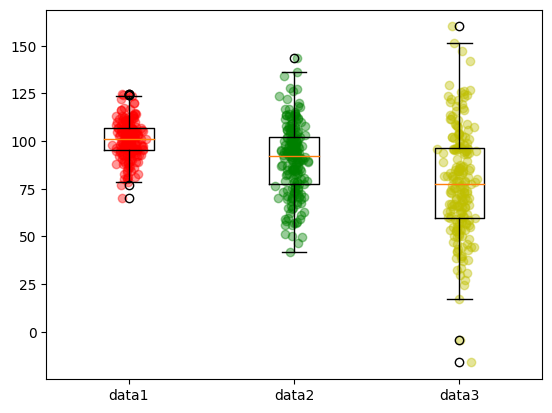

In [35]:
import numpy as np
np.random.seed(10)
data1 = np.random.normal(100, 10, 200)
data2 = np.random.normal(90, 20, 200)
data3 = np.random.normal(80, 30, 200)
data = [data1, data2, data3]
plt.boxplot(data, labels=['data1', 'data2', 'data3'])

palette = ['r', 'g', 'y']
for i, val, c in zip(range(1,len(data)+1), data, palette):
    x = np.random.normal(i, 0.04, size=len(val)) # jitter
    plt.scatter(x, val, alpha=0.4, color=c)
plt.show()



# Boxplot distributions MixMHCpred

In [3]:
import pandas as pd

data = pd.read_csv("predictions_mixmhcpred.csv")
print(data.head(3))

   id          HLA   peptide  Label  Length  \
0   1  HLA-A*01:01  LFGRDLSY      1       8   
1   2  HLA-A*01:01  TDKKTHLY      1       8   
2   3  HLA-A*01:01  RSDTPLIY      1       8   

                                  mhc  mixmhcpred_score  mixmhcpred_rank  
0  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY         -1.768960         2.741370  
1  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY         -1.871118         3.238930  
2  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY          0.103419         0.079745  


In [6]:
# see rank values
print(max(data["mixmhcpred_rank"]))
print(min(data["mixmhcpred_rank"]))
print(sum(data["mixmhcpred_rank"])/len(data["mixmhcpred_rank"]))

98.5726
0.001
17.08436647698179


In [15]:
# getting best threshold
from sklearn.metrics import f1_score, precision_recall_curve
import numpy as np

# Assuming you have your predicted probabilities and true labels
predicted_probs = data["mixmhcpred_rank"]
true_labels = data["Label"]

# Create a range of threshold values to evaluate
# se establecio hasta 30, xq el promedio era 17 de las prob. Luego, al evaluar hasta 100, los resultados bajan
thresholds = np.linspace(0, 30, 100)  # Adjust the number of thresholds as needed


# Initialize variables to store best threshold and best F1-score
best_threshold = None
best_f1_score = 0

# Iterate through thresholds and calculate F1-score for each
for threshold in thresholds:
    binary_predictions = (predicted_probs < threshold).astype(int) # los rank mas pequeños son mejores en mixmhcpred
    f1 = f1_score(true_labels, binary_predictions)
    
    # Update best threshold if F1-score improves
    if f1 > best_f1_score:
        best_threshold = threshold
        best_f1_score = f1

print("Best Threshold:", best_threshold)
print("Best F1-Score:", best_f1_score)

Best Threshold: 3.3333333333333335
Best F1-Score: 0.8821491290521619
